In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import warnings
import numpy as np
import pylab as plt

from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from grid import regridXYZ
from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitLeicaData, parabola
from zernikies import getZernikeCoeffs, zernikePoly
from utils.utils import midPoint, gridLimits
from plotting import surfacePlot, barChartPlot
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [3]:
def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, 
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = fitLeicaData(x_.compressed(), y_.compressed(), z_.compressed(), 
                           guess, bounds=bounds, f_scale=f_scale, ftol=ftol, 
                           xtol=xtol, max_nfev=max_nfev)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask


def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xr, yr, zr = shiftRotateXYZ(x, y, z, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    xg, yg, zg = regridXYZ(xr, yr, zr, n=n)
    
    return xg, yg, zg


def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [39]:
n = 512
nZern = 36
guess = [6.00319194e+01, 2.45282692e+00, -9.96895755e-01, -4.93036183e+01, 2.19838173e-01, -5.05770158e-03]
kernel = Gaussian2DKernel(x_stddev=17.)
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [40]:
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=178.)

In [46]:
%%time

# Use the .zernike.fits files to select signal scans.
fitsDir = '/home/gbtdata/TLASSI_200315'
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

zFitDict = {}

xrg, yrg, zrg = xr, yr, zr
zrgs = convolve(zrg, kernel, boundary='extend', nan_treatment='interpolate', preserve_nan=True)
zrFit, zrMask = parabolaFitIterations(xrg, yrg, zrgs,
                                      guess=guess, bounds=None, iters=10, 
                                      max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)
pFitR = np.copy(zrFit.x)
xra, yra, zra = alignXYZ(xrg, yrg, zrg, pFitR)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,ff in enumerate(zern_files):
        
        time = Time( '{0}T{1}'.format('-'.join(ff.split('/')[-1].split('.')[0].split("_")[:3]), 
                                  ff.split('/')[-1].split('.')[0].split("_")[-1]) )
        mjd = time.mjd

        sf = ff.replace(".zernike.fits", ".fits")
        sigScanFile = "{0}/{1}".format(scanDir, sf.split('/')[-1].replace('.fits', '.ptx.csv'))

        # Find the scan number.
        hdu = fits.open(sf)
        head = hdu[0].header
        scan = head['SCAN']

        xs, ys, zs = prepareData(sigScanFile, n=n, rot=178.)
        
        xsg, ysg, zsg = xs, ys, zs
        zsgs = convolve(zsg, kernel, boundary='extend', nan_treatment='interpolate', preserve_nan=True)
        zsFit, zsMask = parabolaFitIterations(xsg, ysg, zsgs,
                                              guess=guess, bounds=None, iters=10, 
                                              max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)
        
        
        pFitS = np.copy(zsFit.x)
        
        xsa, ysa, zsa = alignXYZ(xsg, ysg, zsg, pFitS)
        
        xmin, xmax = gridLimits(xsa, xra)
        ymin, ymax = gridLimits(ysa, yra)
        xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
        xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
        
        diff = sigma_clip(np.ma.masked_invalid(zsag - zrag), 2.5)

        fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')
        fl_fs_sub = np.copy(fl_fs)
        fl_fs_sub[2] *= -1.
        zpoly_ = zernikePoly(xrg, yrg, midPoint(xrg), midPoint(yrg), fl_fs_sub[:4])
        diff_ = diff - zpoly_
        fl_fs_ = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
        
        zFitDict[scan] = {'recovered zernike': fl_fs,
                          'recovered zernike tilt subtracted': fl_fs_,
                          'mjd': mjd
                         }

CPU times: user 1h 23min 7s, sys: 1h 4min 28s, total: 2h 27min 36s
Wall time: 13min 36s


In [9]:
%%time

asDict = {}

# Use the .zernike.fits files to select signal scans.
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

# Load the ScanLog
hdu = fits.open("{0}/ScanLog.fits".format(fitsDir))
scanArr = hdu[1].data

for i, zf in enumerate(zern_files):
    
    hdu = fits.open(zf)
    head = hdu[0].header
    scan = head['MC_SCAN']

    idx = np.where(scanArr['SCAN'] == scan)[0][0]
    idx_as = idx - 3
    sig_scan = scanArr['SCAN'][idx_as]
    ref_scan = scanArr['SCAN'][idx_as-6]

    # Load the AS fits file for the signal scan.
    as_file = file = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    hdu = fits.open("{0}/{1}".format(fitsDir, as_file))
    z_as = hdu[1].data['value']

    # The AS Zernike contents start at Z1, not Z0.
    # The LASSI Zernike start at Z0.
    z_idx = int(np.where(z_as != 0)[0])

    as_file_sig = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    as_file_ref = '/'.join(scanArr[idx_as - 6]['FILEPATH'].split('/')[-2:])
    #print(as_file_sig, as_file_ref)
    xas, yas, aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/{1}".format(fitsDir, as_file_ref), 
                                                               "{0}/{1}".format(fitsDir, as_file_sig), 
                                                               column='ABSOLUTE', filterDisabled=True, 
                                                               verbose=False, plot=False)
    z_as_obs = fitlist

    z_in = z_as[z_idx]
    z_in_as = z_as_obs[z_idx+1]*1e6 # microns

    asDict[scan] = {'input zernike': z_idx + 1,
                    'input zernike value': z_as[z_idx],
                    'active surface zernike value': z_in_as,
                    'active surface reference scan': ref_scan,
                    'active surface signal scan': sig_scan,
                     }

CPU times: user 30.6 s, sys: 2.65 s, total: 33.3 s
Wall time: 28.6 s


In [10]:
%%time
zindxs = [4, 7, 13]
zcoefs = np.arange(0., 500., 10.)*1e-6 # m
eps_tot, eta_tot = make_aperture_efficiency(zindxs, zcoefs, n=256)

CPU times: user 43.5 s, sys: 58.3 ms, total: 43.6 s
Wall time: 43.6 s


In [47]:
%%time

zin = np.zeros(len(zern_files), dtype=np.float)
mjds = np.zeros(len(zern_files), dtype=np.float)
zobs = np.zeros((len(zern_files),2), dtype=np.float)
zinval = np.zeros(len(zern_files), dtype=np.float)
residuals = np.zeros((len(zern_files),2), dtype=np.float)

for i,k in enumerate(natsorted(list(zFitDict.keys()))):
    
    zi = asDict[k]['input zernike']
    ci = asDict[k]['active surface zernike value']
    if zi == 7:
        ci *= -1
    ci_obs = zFitDict[k]['recovered zernike'][zi]
    ci_obs_ = zFitDict[k]['recovered zernike tilt subtracted'][zi]
    mjds[i] = zFitDict[k]['mjd']
    
    zin[i] = zi
    zinval[i] = ci
    zobs[i,0] = ci_obs
    zobs[i,1] = ci_obs_
    residuals[i,0] = abs(ci - ci_obs)
    residuals[i,1] = abs(ci - ci_obs_)

CPU times: user 0 ns, sys: 1.26 ms, total: 1.26 ms
Wall time: 1.34 ms


In [48]:
time = Time(mjds, format='mjd')
eta_res = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,0]*1e6)
eta_res_wls = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,1]*1e6)
eta_res_comb = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs.mean(axis=1)*1e6)

<IPython.core.display.Javascript object>


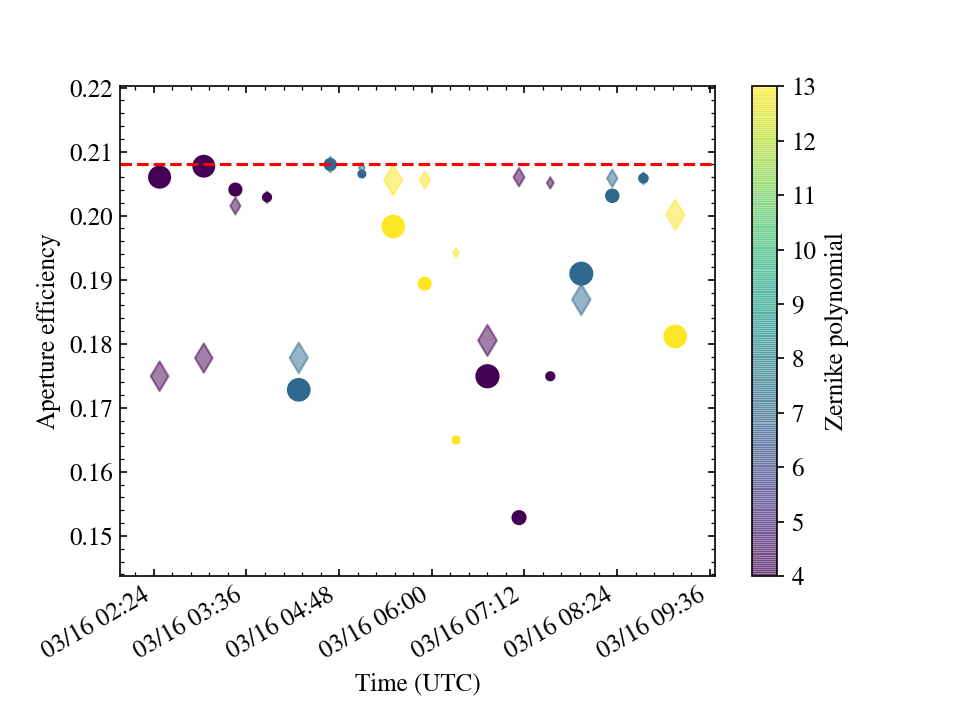

In [51]:
from matplotlib.dates import DateFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

formatter = DateFormatter('%m/%d %H:%M')

fig = plt.figure(dpi=150, frameon=False)

ax = fig.add_subplot(111)
#axt = ax.twiny()

ax.axhline(y=np.max(eta_tot), color='r', linestyle='--')
sc = ax.scatter(time.plot_date, eta_res, c=zin, s=abs(zinval)/5., marker='o')
sc = ax.scatter(time.plot_date, eta_res_wls, c=zin, s=abs(zinval)/5., marker='d', alpha=0.5)
#sc = ax.scatter(time.plot_date, eta_res_comb, c=zin, s=abs(zinval)/5., marker='s')
cb = plt.colorbar(sc)
cb.set_label('Zernike polynomial')
ax.minorticks_on()
ax.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)
#ax.set_xlabel("Scan")
ax.set_ylabel("Aperture efficiency")

ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time (UTC)')

fig.autofmt_xdate()


#plt.savefig("eta_scan_avgrefsimple.pdf", bbox_inches='tight', pad_inches=0.06)

In [55]:
idx = 1
print(zin[idx], zinval[idx], zobs[idx]*1e6, zobs[idx].mean()*1e6, eta_res[idx])

4.0 -496.8822956614909 [-516.7754898 -297.8455805] -407.31053514714205 0.20771612295779587


In [50]:
mask = (zin != 4)
print(np.max(eta_tot), np.mean(eta_res), np.power(np.mean(eta_res)/np.max(eta_tot), -2.))
print(np.max(eta_tot), np.mean(eta_res[mask]), np.power(np.mean(eta_res[mask])/np.max(eta_tot), -2.))

0.20804304085861067 0.1908456600912959 1.18834299181697
0.20804304085861067 0.1920995084610458 1.1728808049960298


In [19]:
mask = (zin != 4)
print(np.max(eta_tot), np.mean(eta_res_wls), np.power(np.mean(eta_res_wls)/np.max(eta_tot), -2.))
print(np.max(eta_tot), np.mean(eta_res_wls[mask]), np.power(np.mean(eta_res_wls[mask])/np.max(eta_tot), -2.))

0.20804304085861067 0.18683924235498325 1.2398529821956676
0.20804304085861067 0.1894125707264506 1.2063929462061955


In [109]:
print(np.max(eta_tot), np.mean(eta_res_comb), np.power(np.mean(eta_res_comb)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res_comb[:7],eta_res_comb[8:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.20804304085861067 0.2003316218338315 1.0784682699275414
0.20804304085861067 0.20408915855011467 1.0391219428654044


In [51]:
60*1.05

63.0

In [17]:
zern_files[7]

'/home/gbtdata/TLASSI_200315/LASSI/2020_03_16_05:30:05.zernike.fits'

In [22]:
list(zFitDict.keys())[7]

63

In [103]:
asDict[81]

{'input zernike': 4,
 'input zernike value': 500.0,
 'active surface zernike value': -552.0855717303331,
 'active surface reference scan': 78,
 'active surface signal scan': 80,
 'mjd': 58924.28005787037}

In [24]:
zFitDict[63]

{'recovered zernike': array([ 0.        , -0.76801783,  0.00591499, -0.57853835,  0.71510513,
         0.8300798 , -0.1285833 ,  0.05315702, -0.0702985 ,  0.39423884,
         0.36629497, -0.50353831, -0.32544331, -0.06204874,  0.15302324,
         0.10679174, -0.05981728,  0.01069216,  0.07006846,  0.07394586,
        -0.07844   , -0.24312863,  0.32336738,  0.17569412, -0.50440582,
        -0.33171099, -0.02934361,  0.02517625, -0.1236888 ,  0.06609827,
        -0.06797294, -0.01703055,  0.00729479, -0.08383448, -0.23762561,
        -0.01856333,  0.14723368]),
 'recovered zernike tilt subtracted': array([ 0.00000000e+00, -3.54862094e-01,  1.72638793e-02, -2.24249092e-01,
         3.00787835e-01,  3.86551119e-01, -6.16936828e-02,  9.36690460e-03,
        -5.69680438e-02,  1.56705849e-01,  1.46674129e-01, -2.29818076e-01,
        -8.52696590e-02, -6.56319482e-03,  8.72810271e-02,  4.26263138e-02,
        -1.28889884e-02,  1.80891510e-02,  4.75176687e-02,  1.69116082e-02,
        -3.7043